In [4]:
#imports
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#provide path to annotation directory containing coco jsons
annotation_dir = "/shared/vision/dataset/metadata/v8/v3.0onwards_8_cls_70_30split_06_27_15_05/"
train_file = "extended_train_annotations_coco_fmt.json"
val_file = "val_annotations_coco_fmt.json"
test_file = "test_annotations_coco_fmt.json"

annotations = []
images = []
videos = []
def load_annotations(dir, file):
    file_path = os.path.join ( dir, file)
    with open(file_path, "r") as f:
        data = json.load(f)
        la = len(data["annotations"])
        li = len(data["images"])
        lv = 0
        annotations.extend(data["annotations"])
        images.extend(data["images"])
        if "videos" in data:
            videos.extend(data["videos"])
            lv = len(data["videos"])
        print(f"file {file} has {lv} videos {li} images and {la} instances")
        return data

train_data = load_annotations(annotation_dir, train_file)
val_data = load_annotations(annotation_dir, val_file)
test_data = load_annotations(annotation_dir, test_file)

# videos = test_data["videos"]
# videos =[]
print(f"total number of {len(videos)} videos {len(images)} images {len(annotations)} annotations: ")

file extended_train_annotations_coco_fmt.json has 0 videos 102884 images and 108844 instances
file val_annotations_coco_fmt.json has 0 videos 14552 images and 17433 instances
file test_annotations_coco_fmt.json has 0 videos 19747 images and 22131 instances
total number of 0 videos 137183 images 148408 annotations: 


class_name
defaultdict(<function <lambda> at 0x76fc74d71620>, {'Zip': 61002, 'Helicopter': 10682, 'Airplane': 47399, 'Bird': 3836, 'Balloon': 10345, 'Ultralight': 6440, 'Paraglider': 7092, 'Glider': 1612})
size_cat
defaultdict(<function <lambda> at 0x76fc74d2a5c0>, {'small': 62569, 'medium': 70432, 'large': 15407})
horizon


KeyError: 'horizon'

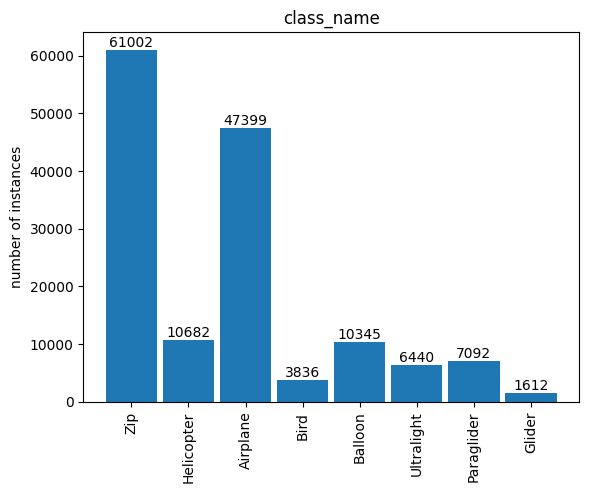

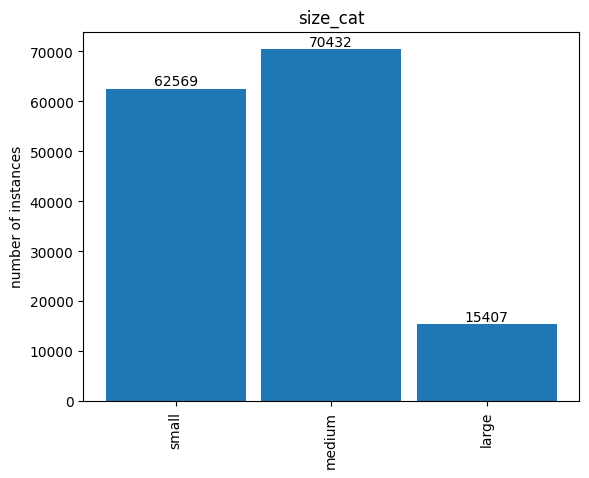

In [5]:
#  Computes and plots the distribution of different attributes
assert len(annotations) > 0, "no annotations found"
attributes = annotations[0]["attributes"].keys()
for attr in attributes:
    print(attr)
    if attr in ["width_rectangle", "difficulty"]:
        continue
    dist = defaultdict(lambda: 0)
    for annot in annotations:
        if type(annot["attributes"][attr])==list:
            attr_key = "mixed"
        else:
            attr_key = annot["attributes"][attr]
            if not attr_key:
                attr_key = 'None'
            dist[attr_key] +=1
    print(dist)
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    bar_container = ax.bar(dist.keys(), dist.values(), width=0.9)
    ax.set(ylabel='number of instances', title=str(attr))
    ax.bar_label(bar_container)

In [ ]:
import json
import cv2
import os
import random
import matplotlib.pyplot as plt

# Define colors for visualization
random.seed(42)
COLORS = {i: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in range(16)}

# Load ground truth and prediction data
with open("/home/rgummadi/YOLOV/gt_refined.json", "r") as f:
    gt_data = json.load(f)

with open("/home/rgummadi/YOLOV/refined_pred.json", "r") as f:
    pred_data = json.load(f)

# Mapping of category IDs to class names
category_mapping = {c["id"]: c["name"] for c in gt_data["categories"]}

# Load images into a dictionary for easy access
image_mapping = {img["id"]: img["file_name"] for img in gt_data["images"]}

# Prediction confidence threshold
CONF_THRESH = 0.1

# Function to draw bounding boxes
def draw_boxes(image, annotations, color, label_prefix="GT", is_prediction=False):
    for ann in annotations:
        if is_prediction and ann["score"] < CONF_THRESH:
            continue  # Skip low-confidence predictions

        x, y, w, h = map(int, ann["bbox"])
        category_id = ann["category_id"]
        class_name = category_mapping.get(category_id, "Unknown")
        label = f"{label_prefix}: {class_name}"

        # Add score to prediction labels
        if is_prediction:
            label += f" ({ann['score']:.2f})"

        # Draw rectangle and label
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Create an output directory
os.makedirs("output_visualization", exist_ok=True)

# Process each image
for image_id, image_name in image_mapping.items():
    # Load image
    if not os.path.exists(image_name):
        continue  # Skip if image is missing

    image = cv2.imread(image_name)

    # Get GT annotations
    gt_annotations = [ann for ann in gt_data["annotations"] if ann["image_id"] == image_id]
    
    # Get Prediction annotations (filtered by confidence threshold)
    pred_annotations = [ann for ann in pred_data if ann["image_id"] == image_id and ann["score"] >= CONF_THRESH]

    # Draw GT and prediction boxes
    draw_boxes(image, gt_annotations, (0, 255, 0), "GT")  # Green for GT
    draw_boxes(image, pred_annotations, (0, 0, 255), "Pred", is_prediction=True)  # Red for predictions

    # Save or show the image
    output_path = os.path.join("output_visualization", os.path.basename(image_name))
    cv2.imwrite(output_path, image)

    # Optional: Show image (comment this out if running on a server)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(image_name)
    plt.show()


In [ ]:
# fix json if it includes missing images
import json
import os
from tqdm.notebook import tqdm

val_file_path = "/shared/users/raajitha/subsampled_anns_ignore_dict_full_data/val_annotations_coco_fmt.json"
output_path = "/shared/users/raajitha/subsampled_anns_ignore_dict_full_data/val_annotations_coco_fmt_fixed.json"
orig_val_data = json.load(open(val_file_path))
img_name_to_id = {img['file_name']:img['id'] for img in orig_val_data['images']}

IMAGES_DIR = "/shared/vision/dataset/"
def get_missing_images(images):
    list_imgs_paths = [img['file_name'] for img in images]
    missing_image_ids = []
    for file_name in tqdm(list_imgs_paths):
        if not os.path.exists(os.path.join(IMAGES_DIR, file_name)):
            missing_image_ids.append(img_name_to_id[file_name])
    return missing_image_ids

missing_image_ids = get_missing_images(orig_val_data['images'])
print(len(missing_image_ids))

if len(missing_image_ids) > 0:
    dataset = {}
    dataset["categories"] = orig_val_data["categories"]
    dataset["images"] = [img for img in orig_val_data['images'] if img['id'] not in missing_image_ids]
    dataset["annotations"] = [annot for annot in orig_val_data['annotations'] if annot['image_id'] not in missing_image_ids]

    with open(output_path, "w") as fp:
        json.dump(dataset, fp, indent=4)